In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/store-sales-time-series-forecasting.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd
import os
import gc
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
stores = pd.read_csv("/content/stores.csv")
submission = pd.read_csv("/content/sample_submission.csv")
transactions = pd.read_csv("/content/transactions.csv").sort_values(["store_nbr", "date"])




In [ ]:
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)

In [ ]:
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00
1,1,2013-01-01,1,BABY CARE,0.00,0.00
2,2,2013-01-01,1,BEAUTY,0.00,0.00
3,3,2013-01-01,1,BEVERAGES,0.00,0.00
4,4,2013-01-01,1,BOOKS,0.00,0.00


In [ ]:
transactions.head()

,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833
93,2013-01-04,1,1863
139,2013-01-05,1,1509
185,2013-01-06,1,520


In [ ]:
train = pd.merge(train, transactions, how="left", on=["store_nbr", "date"])
train.head()


,id,date,store_nbr,family,sales,onpromotion,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,NaN
1,1,2013-01-01,1,BABY CARE,0.00,0.00,NaN
2,2,2013-01-01,1,BEAUTY,0.00,0.00,NaN
3,3,2013-01-01,1,BEVERAGES,0.00,0.00,NaN
4,4,2013-01-01,1,BOOKS,0.00,0.00,NaN


In [ ]:
train = pd.merge(train, stores, how="left", on=["store_nbr"])
train.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.00,0.00,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.00,0.00,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.00,0.00,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.00,0.00,NaN,Quito,Pichincha,D,13


In [ ]:
train.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
transactions,245784
city,0
state,0
type,0


In [ ]:
train["transactions"].fillna(0, inplace=True)
train.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
transactions,0
city,0
state,0
type,0


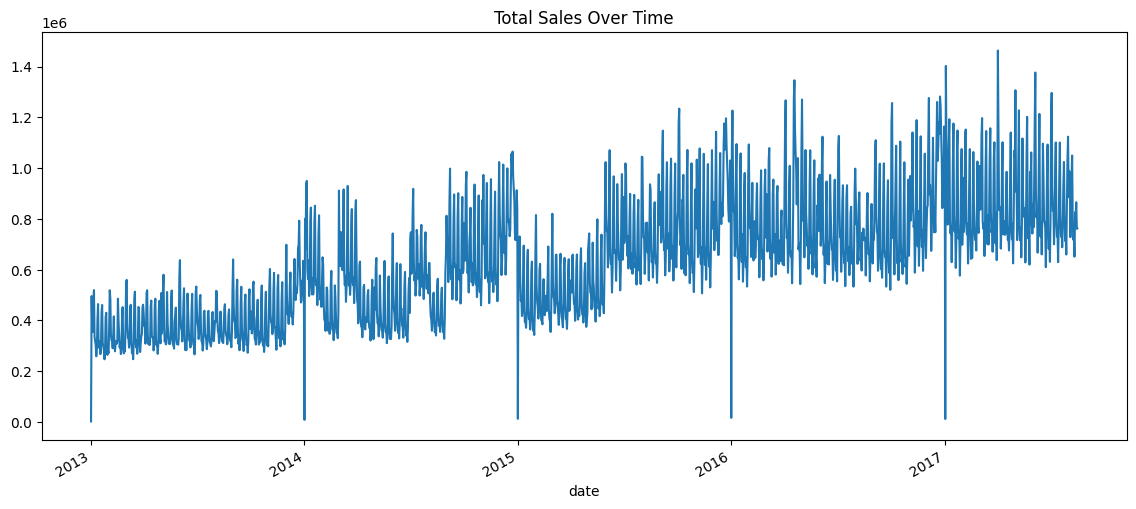

In [ ]:
plt.figure(figsize=(14, 6))
train.groupby("date")["sales"].sum().plot()
plt.title("Total Sales Over Time")
plt.show()

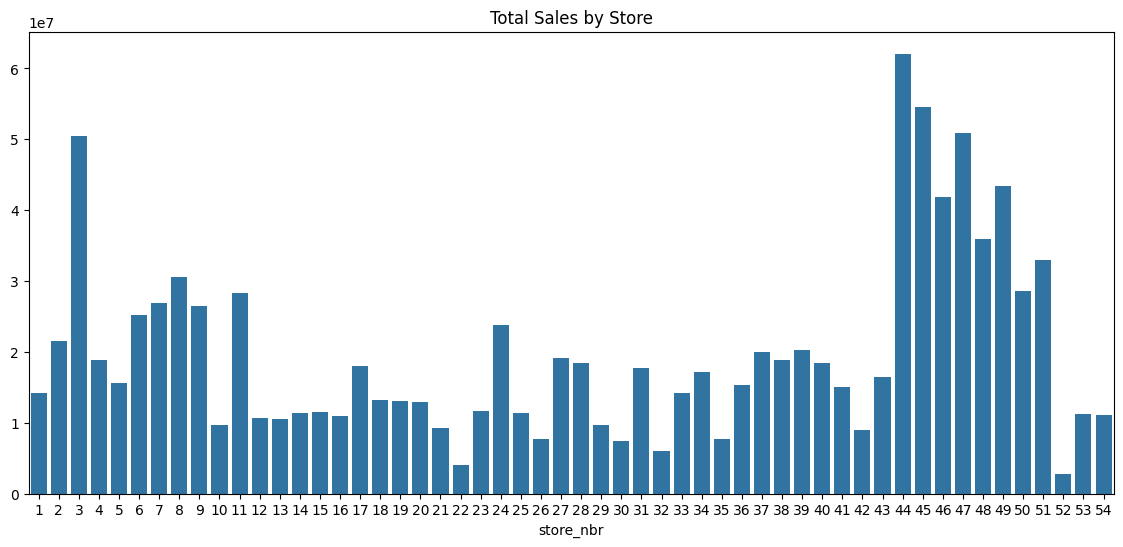

In [ ]:
store_sales = train.groupby("store_nbr")["sales"].sum().sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=store_sales.index, y=store_sales.values)
plt.title("Total Sales by Store")
plt.show()

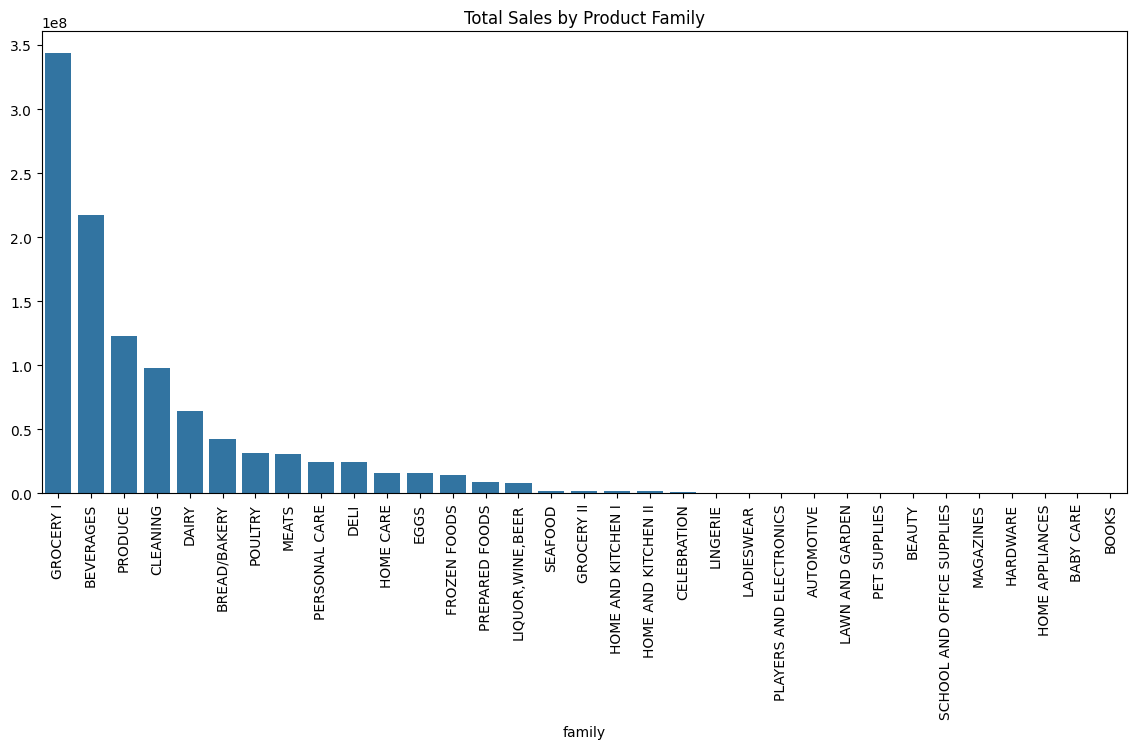

In [ ]:
family_sales = train.groupby("family")["sales"].sum().sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=family_sales.index, y=family_sales.values)
plt.title("Total Sales by Product Family")
plt.xticks(rotation=90)
plt.show()

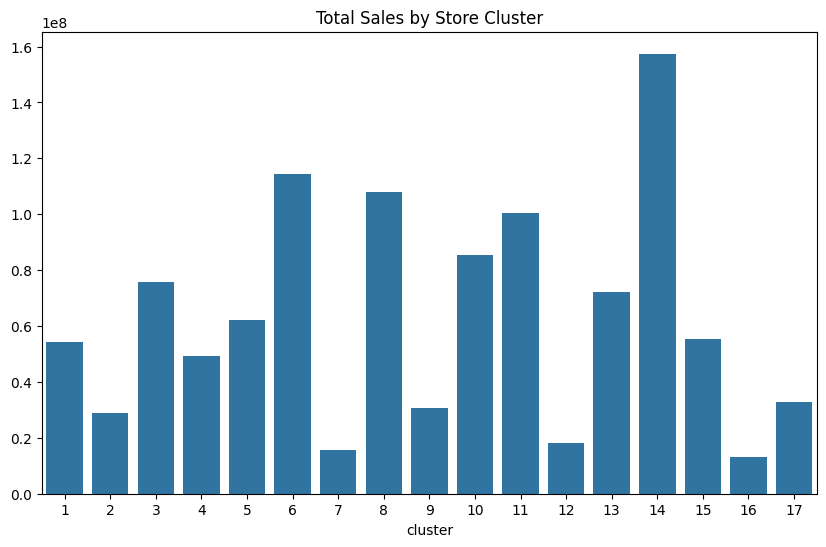

In [ ]:
cluster_sales = train.groupby("cluster")["sales"].sum().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=cluster_sales.index, y=cluster_sales.values)
plt.title("Total Sales by Store Cluster")
plt.show()

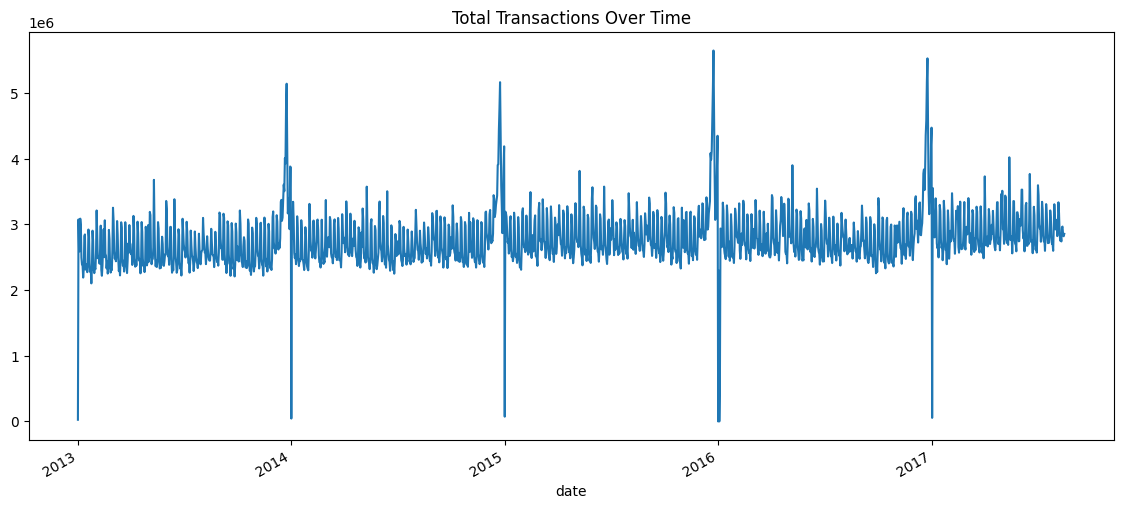

In [ ]:
plt.figure(figsize=(14, 6))
train.groupby("date")["transactions"].sum().plot()
plt.title("Total Transactions Over Time")
plt.show()

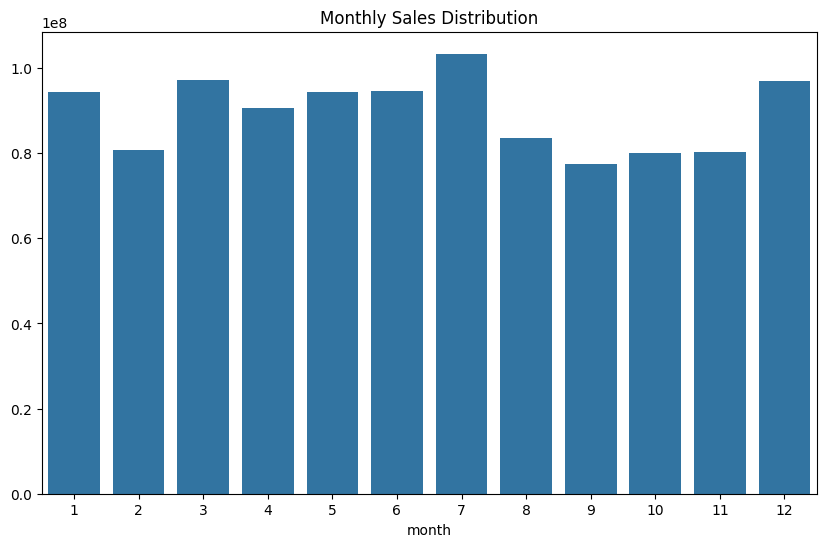

In [ ]:
train['month'] = train['date'].dt.month
monthly_sales = train.groupby("month")["sales"].sum()
plt.figure(figsize=(10,6))
sns.barplot(x=monthly_sales.index, y=monthly_sales.values)
plt.title("Monthly Sales Distribution")
plt.show()

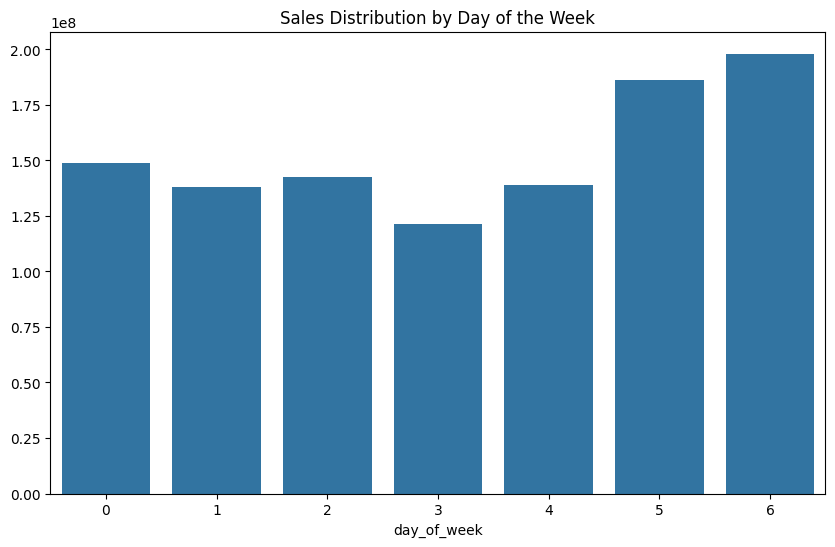

In [ ]:
train['day_of_week'] = train['date'].dt.dayofweek
weekly_sales = train.groupby("day_of_week")["sales"].sum()
plt.figure(figsize=(10,6))
sns.barplot(x=weekly_sales.index, y=weekly_sales.values)
plt.title("Sales Distribution by Day of the Week")
plt.show()

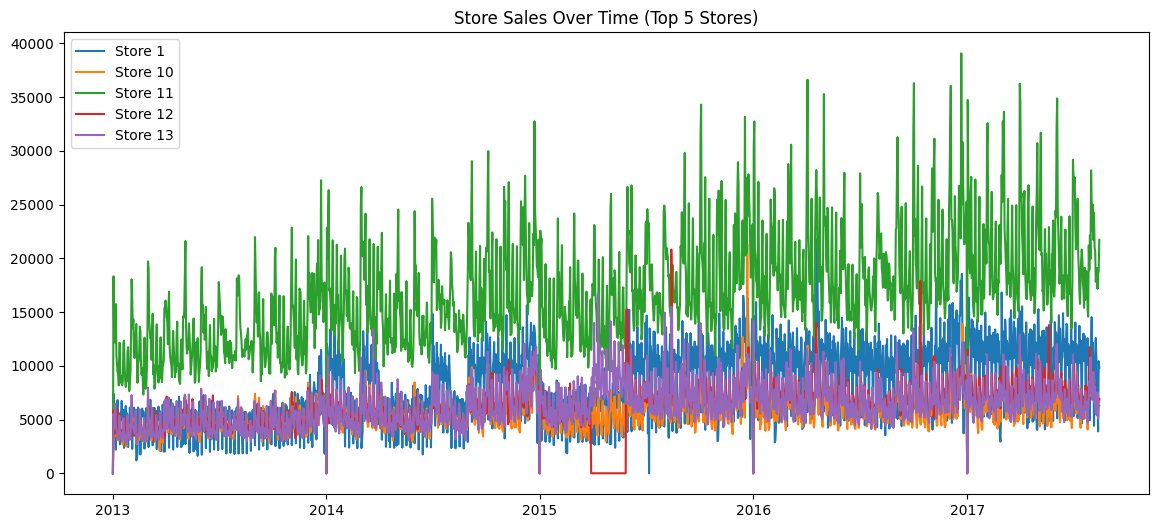

In [ ]:
plt.figure(figsize=(14, 6))
for store in train['store_nbr'].unique()[:5]:
    store_sales = train[train['store_nbr'] == store].groupby("date")["sales"].sum()
    plt.plot(store_sales, label=f'Store {store}')
plt.title("Store Sales Over Time (Top 5 Stores)")
plt.legend()
plt.show()

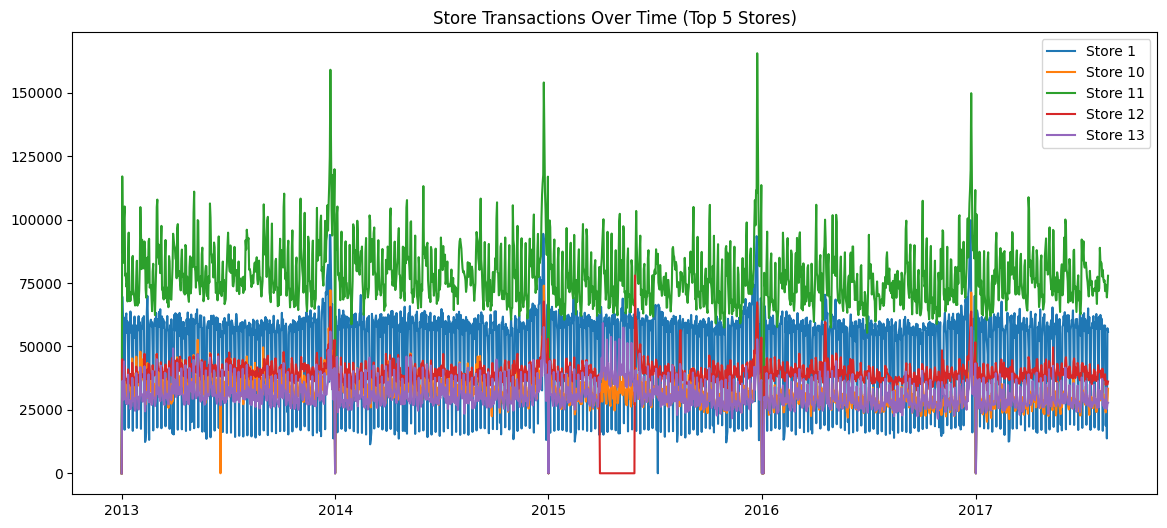

In [ ]:
plt.figure(figsize=(14, 6))
for store in train['store_nbr'].unique()[:5]:  # Limiting to first 5 stores
    store_trans = train[train['store_nbr'] == store].groupby("date")["transactions"].sum()
    plt.plot(store_trans, label=f'Store {store}')
plt.title("Store Transactions Over Time (Top 5 Stores)")
plt.legend()
plt.show()

In [ ]:
train["lag_1"] = train.groupby("store_nbr")["sales"].shift(1)
train["lag_7"] = train.groupby("store_nbr")["sales"].shift(7)
train["lag_30"] = train.groupby("store_nbr")["sales"].shift(30)
train.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster,month,day_of_week,lag_1,lag_7,lag_30
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,0.00,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,0.00,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,0.00,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,0.00,NaN,NaN


In [ ]:
train["rolling_mean_7"] = train.groupby("store_nbr")["sales"].transform(lambda x: x.rolling(7).mean())
train["rolling_std_7"] = train.groupby("store_nbr")["sales"].transform(lambda x: x.rolling(7).std())
train.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster,month,day_of_week,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,NaN,NaN,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,0.00,NaN,NaN,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,0.00,NaN,NaN,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,0.00,NaN,NaN,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,0.00,NaN,NaN,NaN,NaN


In [ ]:
train["expanding_mean"] = train.groupby("store_nbr")["sales"].transform(lambda x: x.expanding().mean())
train.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster,month,day_of_week,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,expanding_mean
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,NaN,NaN,NaN,NaN,NaN,0.00
1,1,2013-01-01,1,BABY CARE,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,0.00,NaN,NaN,NaN,NaN,0.00
2,2,2013-01-01,1,BEAUTY,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,0.00,NaN,NaN,NaN,NaN,0.00
3,3,2013-01-01,1,BEVERAGES,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,0.00,NaN,NaN,NaN,NaN,0.00
4,4,2013-01-01,1,BOOKS,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,0.00,NaN,NaN,NaN,NaN,0.00


In [ ]:
train["day_of_month"] = train["date"].dt.day
train["week_of_year"] = train["date"].dt.isocalendar().week
train["quarter"] = train["date"].dt.quarter
train.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster,month,day_of_week,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,expanding_mean,day_of_month,week_of_year,quarter
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,NaN,NaN,NaN,NaN,NaN,0.00,1,1,1
1,1,2013-01-01,1,BABY CARE,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,0.00,NaN,NaN,NaN,NaN,0.00,1,1,1
2,2,2013-01-01,1,BEAUTY,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,0.00,NaN,NaN,NaN,NaN,0.00,1,1,1
3,3,2013-01-01,1,BEVERAGES,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,0.00,NaN,NaN,NaN,NaN,0.00,1,1,1
4,4,2013-01-01,1,BOOKS,0.00,0.00,0.00,Quito,Pichincha,D,13,1,1,0.00,NaN,NaN,NaN,NaN,0.00,1,1,1


In [ ]:
train.fillna(0, inplace=True)
train.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
transactions,0
city,0
state,0
type,0


In [ ]:
from sklearn.model_selection import train_test_split

X = train.drop(["sales", "date"], axis=1)
y = train["sales"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
X = pd.get_dummies(X, columns=['family', 'city', 'state', 'type'], drop_first=True)

In [ ]:
for col in X_valid.columns:
    unique_values = X_valid[col].unique()
    if any(isinstance(val, str) for val in unique_values):
        print(f"Column {col} has string values.")

In [ ]:
print(X_valid.select_dtypes(include=['object']).columns)


Index([], dtype='object')


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Separate features and target
X = train.drop(["sales", "date"], axis=1)
y = train["sales"]

# Convert categorical columns using one-hot encoding
X = pd.get_dummies(X, columns=['family', 'city', 'state', 'type'], drop_first=True)

# Ensure all columns are numeric
X = X.astype(float)

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Ensure train and valid have the same columns
X_train, X_valid = X_train.align(X_valid, join='left', fill_value=0)

# Initialize and train model
model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = model.predict(X_valid)

In [ ]:
model.save_model("xgb_model.json")

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.load_model("xgb_model.json")
y_pred = model.predict(X_valid)

In [ ]:
test = pd.merge(test, transactions, how="left", on=["store_nbr", "date"])
test = pd.merge(test, stores, how="left", on=["store_nbr"])

# FILLING MISSING VALUES
test["transactions"].fillna(0, inplace=True)
test.head()

,id,date,store_nbr,family,onpromotion,transactions_x,city_x,state_x,type_x,cluster_x,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,day_of_month,week_of_year,quarter,transactions_y,city_y,state_y,type_y,cluster_y,transactions,city,state,type,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0.00,Quito,Pichincha,D,13,0.00,0.00,0.00,0.00,0.00,16,33,3,NaN,Quito,Pichincha,D,13,0.00,Quito,Pichincha,D,13
1,3000889,2017-08-16,1,BABY CARE,0,0.00,Quito,Pichincha,D,13,0.00,0.00,0.00,0.00,0.00,16,33,3,NaN,Quito,Pichincha,D,13,0.00,Quito,Pichincha,D,13
2,3000890,2017-08-16,1,BEAUTY,2,0.00,Quito,Pichincha,D,13,0.00,0.00,0.00,0.00,0.00,16,33,3,NaN,Quito,Pichincha,D,13,0.00,Quito,Pichincha,D,13
3,3000891,2017-08-16,1,BEVERAGES,20,0.00,Quito,Pichincha,D,13,0.00,0.00,0.00,0.00,0.00,16,33,3,NaN,Quito,Pichincha,D,13,0.00,Quito,Pichincha,D,13
4,3000892,2017-08-16,1,BOOKS,0,0.00,Quito,Pichincha,D,13,0.00,0.00,0.00,0.00,0.00,16,33,3,NaN,Quito,Pichincha,D,13,0.00,Quito,Pichincha,D,13


In [ ]:
test["lag_1"] = test.groupby("store_nbr")["transactions"].shift(1)
test["lag_7"] = test.groupby("store_nbr")["transactions"].shift(7)
test["lag_30"] = test.groupby("store_nbr")["transactions"].shift(30)

test["rolling_mean_7"] = test.groupby("store_nbr")["transactions"].transform(lambda x: x.rolling(7).mean())
test["rolling_std_7"] = test.groupby("store_nbr")["transactions"].transform(lambda x: x.rolling(7).std())

test["day_of_month"] = test["date"].dt.day
test["week_of_year"] = test["date"].dt.isocalendar().week
test["quarter"] = test["date"].dt.quarter
test.fillna(0, inplace=True)
test.head()

,id,date,store_nbr,family,onpromotion,transactions,city,state,type,cluster,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,day_of_month,week_of_year,quarter
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0.00,Quito,Pichincha,D,13,0.00,0.00,0.00,0.00,0.00,16,33,3
1,3000889,2017-08-16,1,BABY CARE,0,0.00,Quito,Pichincha,D,13,0.00,0.00,0.00,0.00,0.00,16,33,3
2,3000890,2017-08-16,1,BEAUTY,2,0.00,Quito,Pichincha,D,13,0.00,0.00,0.00,0.00,0.00,16,33,3
3,3000891,2017-08-16,1,BEVERAGES,20,0.00,Quito,Pichincha,D,13,0.00,0.00,0.00,0.00,0.00,16,33,3
4,3000892,2017-08-16,1,BOOKS,0,0.00,Quito,Pichincha,D,13,0.00,0.00,0.00,0.00,0.00,16,33,3
